In [1]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
# Load the SPICE kernels via a meta file
spiceypy.furnsh('Data/kernel_meta.txt')

In [3]:
# Create an initial date-time object that is converted to a string
DATETIME_UTC = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
DATETIME_ET = spiceypy.utc2et(DATETIME_UTC)

In [4]:
# We want to compute the coordinates for different Solar System bodies as seen
# from our planet. First, a pandas dataframe is set that is used to append the
# computed data
solsys_df = pd.DataFrame()

# Add the ET and the corresponding UTC date-time string
solsys_df.loc[:, 'ET'] = [DATETIME_ET]
solsys_df.loc[:, 'UTC'] = [DATETIME_UTC]

# # Set a dictionary that lists some body names and the corresponding NAIF ID
# # code. Mars has the ID 499, however the loaded kernels do not contain the
# # positional information. We use the Mars barycentre instead
SOLSYS_DICT = {'SUN': 10, 'VENUS': 299, 'MOON': 301, 'MARS': 4}

In [5]:
for body_name in SOLSYS_DICT:

    # First, compute the directional vector of the body as seen from Earth in
    # J2000
    solsys_df.loc[:, f'dir_{body_name}_wrt_earth_equ'] = solsys_df['ET'] \
        .apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name], \
                                         et=x, \
                                         ref='J2000', \
                                         abcorr='LT+S', \
                                         obs=399)[0])

    # Compute the longitude and latitude values in equatorial J2000
    # coordinates
    solsys_df.loc[:, f'{body_name}_long_rad_equ'] = \
        solsys_df[f'dir_{body_name}_wrt_earth_equ'] \
            .apply(lambda x: spiceypy.recrad(x)[1])
    solsys_df.loc[:, f'{body_name}_lat_rad_equ'] = \
        solsys_df[f'dir_{body_name}_wrt_earth_equ'] \
            .apply(lambda x: spiceypy.recrad(x)[2])

    # Apply the same logic as shown before to compute the longitudes for the
    # matplotlib figure
    solsys_df.loc[:, f'{body_name}_long_rad4plot_equ'] = \
        solsys_df[f'{body_name}_long_rad_equ'] \
            .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
                   else -1*x)

In [6]:
solsys_df

,ET,UTC,dir_SUN_wrt_earth_equ,SUN_long_rad_equ,SUN_lat_rad_equ,SUN_long_rad4plot_equ,dir_VENUS_wrt_earth_equ,VENUS_long_rad_equ,VENUS_lat_rad_equ,VENUS_long_rad4plot_equ,dir_MOON_wrt_earth_equ,MOON_long_rad_equ,MOON_lat_rad_equ,MOON_long_rad4plot_equ,dir_MARS_wrt_earth_equ,MARS_long_rad_equ,MARS_lat_rad_equ,MARS_long_rad4plot_equ
0,7.369144e+08,2023-05-09T14:26:15,"[100274693.38672791, 103593727.15377118, 44905...",0.801677,0.301943,-0.801677,"[-4464685.814064002, 122972781.33009055, 60252...",1.607087,0.45533,-1.607087,"[54426.78474861237, -322528.09054690506, -1732...",4.879565,-0.487204,1.403621,"[-107961914.5609639, 225292915.3730853, 106345...",2.017671,0.402446,-2.017671


In [7]:
solsys_df['SUN_lat_rad_equ'][0]*180/np.pi

17.300057047866712

In [8]:
solsys_df['SUN_long_rad_equ'][0]*180/np.pi

45.93270859718383

In [9]:
solsys_df['dir_SUN_wrt_earth_equ'][0]

array([1.00274693e+08, 1.03593727e+08, 4.49059328e+07])

In [10]:
# Before we plot the data, let's add the Ecliptic plane for the visualisation.
# In ECLIPJ2000 the Ecliptic plane is the equator line (see corresponding
# figure. The latitude is 0 degrees.

# First, we create a separate dataframe for the ecliptic plane
eclip_plane_df = pd.DataFrame()

# Add the ecliptic longitude and latitude values for the plane. Note: here,
# we need to use pi/2 (90 degrees) as the latitude, since we will apply a
# SPICE function that expects spherical coordinates
eclip_plane_df.loc[:, 'ECLIPJ2000_long_rad'] = np.linspace(0, 2*np.pi, 100)
eclip_plane_df.loc[:, 'ECLIPJ2000_lat_rad'] = np.pi/2.0

# Compute the directional vectors of the ecliptic plane for the different
# longitude values (the latitude is constant). Apply the SPICE function sphrec
# to transform the spherical coordinates to vectors. r=1 is the distance,
# here in our case: normalised distance
eclip_plane_df.loc[:, 'ECLIPJ2000_direction'] = \
    eclip_plane_df\
        .apply(lambda x: spiceypy.sphrec(r=1, \
                                         colat=x['ECLIPJ2000_lat_rad'], \
                                         lon=x['ECLIPJ2000_long_rad']), \
               axis=1)

In [11]:
# Compute a transformation matrix between ECLIPJ2000 and J2000 for a fixed
# date-time. Since both coordinate system are inertial (not changing in time)
# the resulting matrix is the same for different ETs
ECL2EQU_MAT = spiceypy.pxform(fromstr='ECLIPJ2000', \
                              tostr='J2000', \
                              et=DATETIME_ET)

# Compute the direction vectors of the Ecliptic plane in J2000 using the
# transformation matrix
eclip_plane_df.loc[:, 'j2000_direction'] = \
    eclip_plane_df['ECLIPJ2000_direction'].apply(lambda x: ECL2EQU_MAT.dot(x))

# Compute now the longitude (and matplotlib compatible version) and the
# latitude values using the SPICE function recrad
eclip_plane_df.loc[:, 'j2000_long_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: spiceypy.recrad(x)[1])

eclip_plane_df.loc[:, 'j2000_long_rad4plot'] = \
    eclip_plane_df['j2000_long_rad'] \
        .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
               else -1*x)

eclip_plane_df.loc[:, 'j2000_lat_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: spiceypy.recrad(x)[2])

In [12]:
BODY_COLOR_ARRAY = ['y', 'tab:orange', 'tab:gray', 'tab:red']

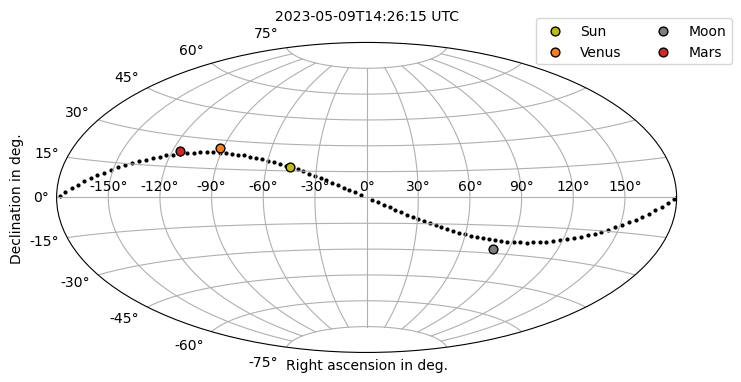

In [13]:
# We plot now the data in equatorial J2000. Again with a dark background and
# the same properties as before
# plt.style.use('dark_background')
plt.figure(figsize=(8, 5))
plt.subplot(projection="aitoff")
plt.title(f'{DATETIME_UTC} UTC', fontsize=10, pad = 16)

# Iterate through the celestial bodies and plot them
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    plt.scatter(solsys_df[f'{body_name}_long_rad4plot_equ'], \
             solsys_df[f'{body_name}_lat_rad_equ'], \
             facecolor=body_color, marker='o', s=40, \
             label=body_name.capitalize(), zorder = 2, edgecolor = 'k')

# Plot the Ecliptic plane as a blue dotted line
plt.plot(eclip_plane_df['j2000_long_rad4plot'], \
         eclip_plane_df['j2000_lat_rad'], color='black', linestyle='None', \
         marker='o', markersize=2, zorder = 0)

# Convert the longitude values finally in right ascension hours
# plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
#                              30, 60, 90, 120, 150]),
#            labels=['10h', '8h', '6h', '4h', '2h', '0h', \
#                    '22h', '20h', '18h', '16h', '14h'])

# Plot the labels
plt.xlabel('Right ascension in deg.')
plt.ylabel('Declination in deg.')

# Create a legend and grid
plt.legend(bbox_to_anchor = (1.1,1.1), ncol = 2)
plt.grid(True)

# Save the figure
# plt.savefig('j2000_sky_map.png', dpi=300)
plt.show()